## Project Documentation: Heart Rate and Arrhythmia Detection using DSP <br>

## What is an ECG Signal ? <br>
An Electrocardiogram (ECG or EKG) is a fundamental diagnostic tool in cardiology and healthcare. It records the electrical activity of the heart over time, producing a characteristic waveform known as the ECG signal. The ECG signal provides critical information about the heart's rhythm, rate, and overall cardiac health. It is widely used for various medical purposes, and this project offers valuable insights into its analysis and interpretation.
The objective of this project is to analyze heart rate data, perform signal processing and filtering to detect heartbeats, calculate heart rate, and identify arrhythmias in the recorded signal.

**Objective:**
The objective of this project is to analyze heart rate data, perform signal processing and filtering to detect heartbeats, calculate heart rate, and identify arrhythmias in the recorded signal.

Here is the code for that :-

Importing all the required modules

In [1]:
import csv
import math
import pandas as pd
import numpy as np
import tkinter as tk
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import scipy.fftpack   
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg 
import scipy.signal as signal               

In [2]:
dataset = pd.read_csv("noise.csv")
y = [e for e in dataset.hart]

In [3]:
dataset

,hart
0,-5.955
1,-5.955
2,-5.955
3,-5.955
4,-5.955
...,...
3595,-6.170
3596,-6.175
3597,-6.175
3598,-6.160


The Fast Fourier Transform (FFT) is calculated in this code to analyze the frequency domain characteristics of the ECG signal.We calculate FFT to visualize the frequency components in the ECG signal, which can be useful for detecting abnormal patterns or disturbances that may indicate arrhythmias or other cardiac conditions. 

In [4]:
N = len(y)
Fs = 1000
T = 1.0 / Fs
x = np.linspace(0.0, N*T, N)

yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

Defining the graph windows

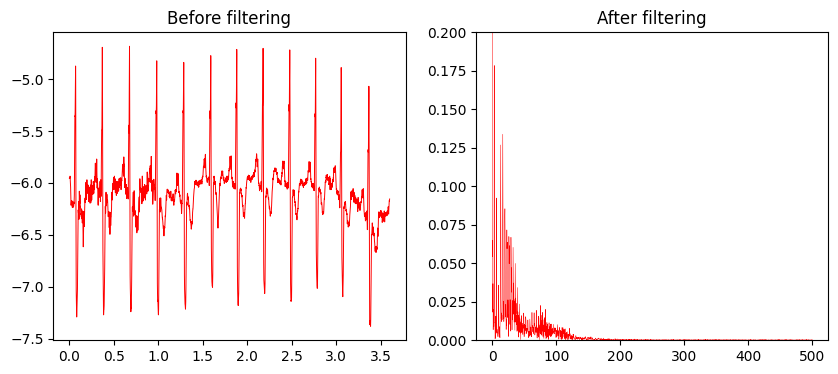

In [5]:
td = tk.Tk()
fig_td, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
canvas_td = FigureCanvasTkAgg(fig_td, master=td)
canvas_td.get_tk_widget().pack()
td.title("Time Domain Signal")


ax1.set_title('Before filtering')
ax2.set_title('After filtering')
ax1.plot(x,y, color='r', linewidth=0.7)
ax2.plot(xf, 2.0/N * np.abs(yf[:N//2]), color='r', linewidth=0.35, label='raw')
ax2.set_ylim([0 , 0.2])  
plt.show()

Plotting the graph of non filtered inputs in frequency and time domain

We have used Butterworth low-pass filter to filter our signal.
It gives filter coefficients b and a, which can be used further to filter the input signal (y) and remove 50hz brum noise from it.

In [6]:
b, a = signal.butter(4, 50/(Fs/2), 'low')

Now we are using coefficients a and b. This function performs zero-phase digital filtering, which means it filters the signal both forward and backward in time to eliminate phase distortion.

In [7]:
tempf = signal.filtfilt(b,a, y)
yff = scipy.fftpack.fft(tempf)

Here we calculated nyquist rate which is half of the sampling frequency Fs. In signal processing, it is the maximum frequency that can be represented in a discrete signal.
A Kaiser window, also known as a Kaiser-Bessel window, is a type of window function used in digital signal processing and spectral analysis. 
Here we use Kaiser Window to remove the baseline drift noise.

In [8]:
nyq_rate = Fs/ 2.0
width = 5.0/nyq_rate
ripple_db = 60.0
O, beta = signal.kaiserord(ripple_db, width)
cutoff_hz = 4.0

This code designs a high-pass FIR filter using the firwin function with a Kaiser window,we apply the filter to the input signal tempf using lfilter, and then compute the FFT of the filtered signal for further analysis in the frequency domain. The purpose is to remove low-frequency components and keep the high-frequency components in the signal.

In [9]:
taps = signal.firwin(O, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=False)
y_filt = signal.lfilter(taps, 1.0, tempf)
yff = scipy.fftpack.fft(y_filt)

Plotting the filtered outputs in frequency and time domain

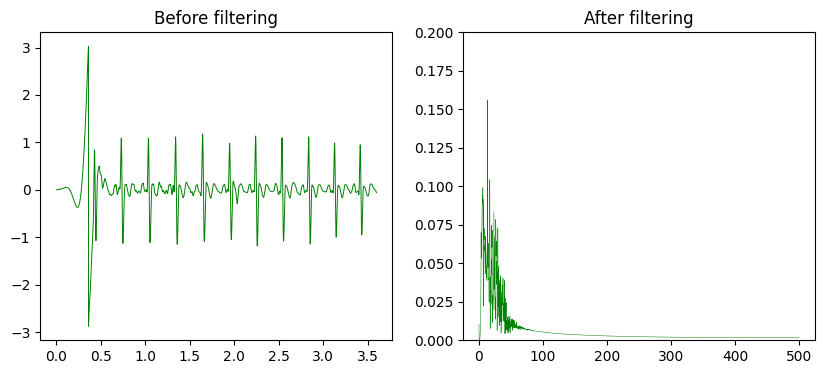

In [10]:
fig_fd, (ax3, ax4) = plt.subplots(1, 2, figsize=(10,4))
fd = tk.Tk()
canvas_fd = FigureCanvasTkAgg(fig_fd, master=fd)
canvas_fd.get_tk_widget().pack()
fd.title("Frequency Domain Signal")
ax3.set_title('Before filtering')
ax4.set_title('After filtering')

ax4.plot(xf, 2.0/N * np.abs(yff[:N//2]), color='g', linewidth=0.35)
ax4.set_ylim([0 , 0.2])
ax3.plot(x,y_filt, color='g', linewidth=0.7)
plt.show()

Now we compute the beats
This code processes the 'filt' column in a dataset to calculate a moving average. We then apply various data transformations to obtain a smoothed and adjusted version of the signal in a new column 'filt_rollingmean' in the dataset. We use it to enhance the clarity of relevant features in the data.

In [11]:
dataset['filt']=y_filt
hrw = 1 #One-sided window size, as proportion of the sampling frequency
fs = 333 #The example dataset was recorded at 300Hz
#Calculating the moving average
mov_avg = dataset.filt.rolling(int(hrw * fs)).mean()

#Imputing where moving average function returns NaN, which is the beginning of the signal
avg_hr = (np.mean(dataset.filt)) 
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
mov_avg = [(0.5+x) for x in mov_avg]
mov_avg = [x*1.2 for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering
dataset['filt_rollingmean'] = mov_avg #Append the moving average to the dataframe

Now we mark the regions of interest to mark the peaks and then measure the interval between peaks to calculate the heartbeats

In [12]:
window = []
peaklist = []
listpos = 0 #We use a counter to move over the different data columns
for datapoint in dataset.filt:
    rollingmean = dataset.filt_rollingmean[listpos] #Get local mean
    
    if (datapoint < rollingmean) and (len(window) < 1): #No detectable R-complex activity -> do nothing
        listpos += 1

    elif (datapoint > rollingmean): #Signal comes above local mean, mark ROI
        window.append(datapoint)
        listpos += 1
        
    else: #Signal drops below local mean -> determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition) #Add detected peak to list
        window = [] #Clear marked ROI
        listpos += 1

ybeat = [dataset.filt[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes

Plotting the detected peaks

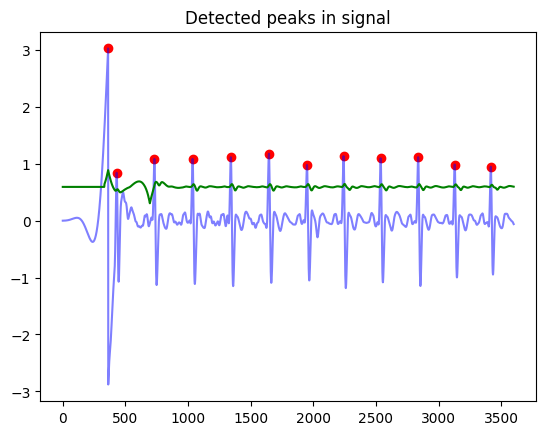

In [13]:
fig_hr= plt.figure()
ax5 = fig_hr.add_subplot(111)
ax5.set_title("Detected peaks in signal")
ax5.plot(dataset.filt, alpha=0.5, color='blue') #Plotting semi-transparent HR
ax5.plot(mov_avg, color ='green') #Plotting moving average
ax5.scatter(peaklist, ybeat, color='red') #Plotting detected peaks

Now we use the data from the peaks to calculate the interval between the peaks and find the average heart beat

In [14]:
RR_list = []
cnt = 0
while (cnt < (len(peaklist)-1)):
    RR_interval = (peaklist[cnt+1] - peaklist[cnt]) #Calculate distance between beats
    ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
    RR_list.append(ms_dist) #Append to list
    print(ms_dist)
    cnt += 1
#Calculating heart rate
bpm = 60000 / np.mean(RR_list) #60000 ms (1 minute) / average R-R interval of signal
print("\n\n\nAverage Heart Beat is: %.01f\n" %(bpm)) #Round off to 1 decimal and print
print("No of peaks in sample are {0}".format(len(peaklist)))

204.20420420420422
903.9039039039038
915.9159159159159
915.9159159159159
912.9129129129129
912.9129129129129
876.8768768768768
888.8888888888888
900.9009009009009
873.8738738738738
864.8648648648649



Average Heart Beat is: 72.0

No of peaks in sample are 12


Displaying the graphs

In [15]:
plt.show()

Now we are using the data about intervals for arrhythmia detection. We take two conditions into consideration tachycardia and bradycardia. We have set the threshold values for interval distances according to research for each condition and we use it to determine whether a patient suffers from a condition or not. 

In [16]:
tachycardia_threshold = 800  # Example threshold for tachycardia (milliseconds)
bradycardia_threshold = 900  # Example threshold for bradycardia (milliseconds)

If a condition is detected we print the condition at that peak or else we print normal if no condition is detected.
### Types of Arrhythmia
**Bradycardia**: Slow heart rate <br>
**Tachycardia**: Fast heart rate

In [17]:
arrhythmias = []
for interval in RR_list:
    if interval < tachycardia_threshold:
        arrhythmias.append("Tachycardia")
    elif interval > bradycardia_threshold:
        arrhythmias.append("Bradycardia")
    else:
        arrhythmias.append("Normal")

for i, arrhythmia in enumerate(arrhythmias):
    if arrhythmia != "Normal":
        print(f"Arrhythmia detected at R-peak {i + 1}: {arrhythmia}")
    else:
        print("Normal")


Arrhythmia detected at R-peak 1: Tachycardia
Arrhythmia detected at R-peak 2: Bradycardia
Arrhythmia detected at R-peak 3: Bradycardia
Arrhythmia detected at R-peak 4: Bradycardia
Arrhythmia detected at R-peak 5: Bradycardia
Arrhythmia detected at R-peak 6: Bradycardia
Normal
Normal
Arrhythmia detected at R-peak 9: Bradycardia
Normal
Normal


In summary, the ECG signal analysis project provides a versatile and powerful solution for the interpretation of ECG data. Its applications range from clinical diagnosis and research to educational purposes and the advancement of remote healthcare services. By automating the analysis of ECG signals, this project contributes to more accurate and timely cardiac assessments, ultimately improving patient care and cardiac health outcomes.

**Conclusion:**
This project successfully achieves the goals of analyzing heart rate data, detecting heartbeats, calculating heart rate, and identifying arrhythmias based on predefined criteria. It employs signal processing techniques and visualization to provide insights into the heart rate data, making it a valuable tool for medical and healthcare applications.